In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12345)

In [2]:
################################################
# functions to check coverage
# for each distribution-free prediction method
# ( base algorithm = ridge regression )
################################################

def PI_split_conformal(X,Y,Xtest,alpha,lambda_ridge,holdout_frac=0.5):
    n = X.shape[0]
    n0 = int(n*(1-holdout_frac))
    ntest = Xtest.shape[0]
    Xtrain = X[:n0]; Ytrain = Y[:n0]
    Xholdout = X[n0:]; Yholdout = Y[n0:]
    betah = np.linalg.solve(Xtrain.T.dot(Xtrain) + lambda_ridge*np.eye(d), Xtrain.T.dot(Ytrain))
    holdout_resids = np.abs(Yholdout - Xholdout.dot(betah))
    q = np.sort(holdout_resids)[(np.ceil((1-alpha)*(n-n0+1))).astype(int)]
    PIs = np.c_[Xtest.dot(betah)-q,Xtest.dot(betah)+q]
    return PIs

def PI_full_conformal(X,Y,Xtest,alpha,lambda_ridge):
    n = X.shape[0]
    ntest = Xtest.shape[0]
    PIs = np.zeros((ntest,2))
    for itest in np.arange(ntest):
        XtX_ = X.T.dot(X) + np.outer(Xtest[itest],Xtest[itest]) + lambda_ridge*np.eye(d)
        beta1 = np.linalg.solve(XtX_, (X.T).dot(Y))
        beta2 = np.linalg.solve(XtX_, Xtest[itest])
        a = Y - X.dot(beta1)
        b = -X.dot(beta2)
        a1 = -Xtest[itest].T.dot(beta1)
        b1 = 1 - Xtest[itest].T.dot(beta2)
        y_knots = np.sort(np.unique(np.r_[((a-a1)[b1-b!=0]/(b1-b)[b1-b!=0]),((-a-a1)[b1+b!=0]/(b1+b)[b1+b!=0])]))
        y_inds_keep = np.where( ((np.abs(np.outer(a1+b1*y_knots,np.ones(n))) > \
            np.abs(np.outer(np.ones(len(y_knots)),a)+np.outer(y_knots,b))) ).mean(1) <= 1-alpha )[0] 
        PIs[itest] = np.array([y_knots[y_inds_keep.min()],y_knots[y_inds_keep.max()]])
    return PIs

def PI_jackknife_plus(X,Y,Xtest,alpha,lambda_ridge):
    n = X.shape[0]
    d = X.shape[1]
    ntest = Xtest.shape[0]
    betah = np.zeros((n,d))
    R = np.zeros(n)
    for i in np.arange(n):
        X_ = np.delete(X,i,0)
        Y_ = np.delete(Y,i)
        betah[i] = np.linalg.solve(X_.T.dot(X_) + lambda_ridge*np.eye(d), X_.T.dot(Y_))
        R[i] = np.abs(Y[i] - X[i].dot(betah[i]))
    PIs = np.zeros((ntest,2))
    for itest in np.arange(ntest):
        muh = betah.dot(Xtest[itest])
        q_lo = np.sort(muh-R)[::-1][(np.ceil((1-alpha)*(n+1))).astype(int)]
        q_hi = np.sort(muh+R)[(np.ceil((1-alpha)*(n+1))).astype(int)]
        PIs[itest] = np.array([q_lo,q_hi])
    return PIs

def PI_CV_plus(X,Y,Xtest,alpha,lambda_ridge,K_CV=20):
    n = X.shape[0]
    d = X.shape[1]
    m = int(n/K_CV)
    ntest = Xtest.shape[0]
    betah = np.zeros((K_CV,d))
    R = np.zeros(n)
    for k in np.arange(K_CV):
        fold = np.arange(k*m,(k+1)*m)
        X_ = np.delete(X,fold,0)
        Y_ = np.delete(Y,fold)
        betah[k] = np.linalg.solve(X_.T.dot(X_) + lambda_ridge*np.eye(d), X_.T.dot(Y_))
        R[fold] = np.abs(Y[fold] - X[fold].dot(betah[k]))
    PIs = np.zeros((ntest,2))
    for itest in np.arange(ntest):
        muh = np.repeat(betah.dot(Xtest[itest]),m)
        q_lo = np.sort(muh-R)[::-1][(np.ceil((1-alpha)*(n+1))).astype(int)]
        q_hi = np.sort(muh+R)[(np.ceil((1-alpha)*(n+1))).astype(int)]
        PIs[itest] = np.array([q_lo,q_hi])
    return PIs

In [3]:
################################################
# run simulation
################################################

n = 500
ntest = 1000
beta_amp = np.sqrt(10)
ntrial = 200
alpha = 0.1
lambda_ridge = 0.0001
dim_list = np.array([125, 250, 475, 500, 1000])
ndim = len(dim_list)
alpha_given_traindata = np.zeros((ndim,ntrial,4))

for idim in np.arange(ndim):
    d = dim_list[idim]
    for itrial in range(ntrial):
        beta = np.random.normal(size=d)
        beta = beta/np.sqrt((beta**2).sum()) * beta_amp
        X = np.random.normal(size=(n,d))
        Y = X.dot(beta) + np.random.normal(size=n)        
        Xtest = np.random.normal(size=(ntest,d))
        Ytest = Xtest.dot(beta) + np.random.normal(size=ntest)
        
        method_fns = [PI_split_conformal,PI_full_conformal,\
                     PI_jackknife_plus,PI_CV_plus]
        for method in np.arange(4):
            PIs = method_fns[method](X,Y,Xtest,alpha,lambda_ridge)
            alpha_given_traindata[idim,itrial,method] = np.mean((PIs[:,0]>Ytest)|(PIs[:,1]<Ytest))
    np.savetxt(('sim_results/results_d_%d.txt' %d),alpha_given_traindata[idim])

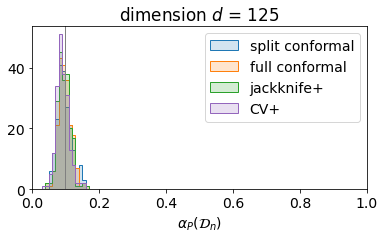

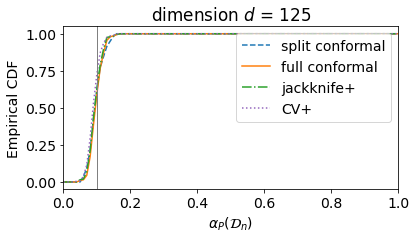

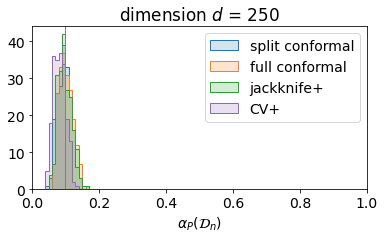

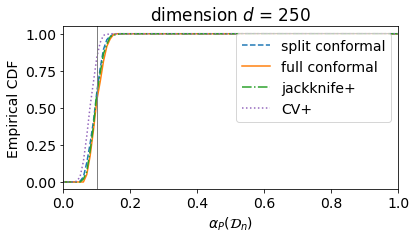

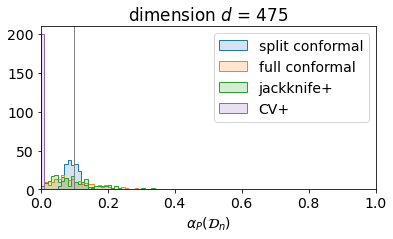

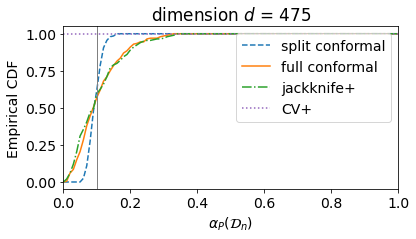

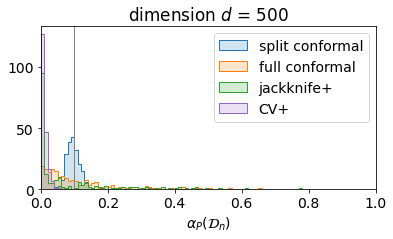

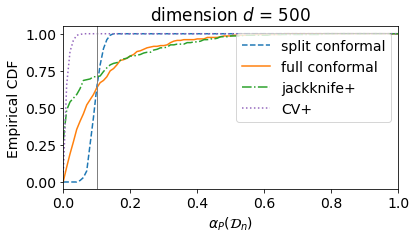

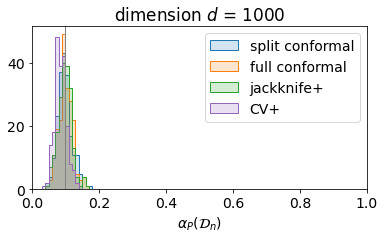

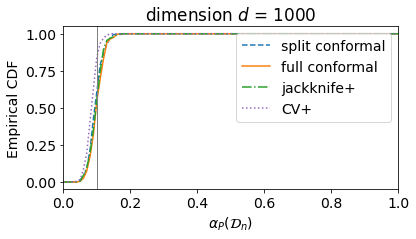

In [4]:
methods = ['split conformal','full conformal','jackknife+','CV+']
lightcolors = [(0.12,0.47,0.71,0.2),(1,0.5,0.05,0.2),(0.17,0.63,0.17,0.2),(0.58,0.4,0.74,0.2)]
colors = [(0.12,0.47,0.71,1),(1,0.5,0.05,1),(0.17,0.63,0.17,1),(0.58,0.4,0.74,1)]
linestyles = ['dashed','solid','dashdot','dotted']
plt.rcParams.update({'font.size': 14})
grid = np.linspace(0,1,101)
for idim in np.arange(ndim):
    plt.figure(figsize=(6,3))
    ax = plt.gca()
    ax.set_xlim([0, 1])
    for method in np.arange(4):
        plt.hist(alpha_given_traindata[idim,:,method], grid, label=methods[method],\
                 histtype='stepfilled', color=lightcolors[method], edgecolor=colors[method])
    plt.legend(loc='upper right')
    plt.axvline(alpha, color='gray', linewidth=1)
    plt.title('dimension '+r'$d$'+f' = {dim_list[idim]}')
    plt.xlabel(r'$\alpha_P(\mathcal{D}_n)$')
    plt.savefig(('figs/plot_hist_d_%d.png' %dim_list[idim]),\
                dpi=400,bbox_inches='tight')
    plt.show()
        
    plt.figure(figsize=(6,3))
    ax = plt.gca()
    ax.set_xlim([0, 1])
    for method in np.arange(4):
        alpha_CDF = np.mean(np.subtract.outer(grid,alpha_given_traindata[idim,:,method])>=0,1)
        plt.plot(grid, alpha_CDF, label=methods[method],\
                 color=colors[method], linestyle=linestyles[method])
    plt.legend(loc='upper right')
    plt.axvline(alpha, color='gray',linewidth=1)
    plt.title('dimension '+r'$d$'+f' = {dim_list[idim]}')
    plt.xlabel(r'$\alpha_P(\mathcal{D}_n)$')
    plt.ylabel('Empirical CDF')
    plt.savefig(('figs/plot_cdf_d_%d.png' %dim_list[idim]),\
                dpi=400,bbox_inches='tight')
    plt.show()